# Home Credit Default Risk
Home Credit is an international non-bank, consumer finance group. The company operates in 14 countries and focuses on lending primarily to people with little or no credit history.

*Credit* is the trust which allows one party to provide money or resources to another party where that second party does not reimburse the first party immediately (*thereby generating a debt*), but instead promises either to repay or return those resources at a later date. A *credit bureau* is a collection agency that gathers account information from various creditors.

This notebook aims to be able to **predict how capable an applicant is of repaying a loan**, using datasets, provided by Home Credit.

[Link](https://www.kaggle.com/c/home-credit-default-risk/data) to the datasets.

## Attributes

A **cash loan** is the lending of money by one or more individuals, organizations, or other entities to other individuals, organizations etc. The recipient (i.e. the borrower) incurs a debt, and is usually liable to pay interest on that debt until it is repaid, and also to repay the principal amount borrowed.  
**Revolving credit/loan** is a type of credit that does not have a fixed number of payments, in contrast to installment credit. Credit cards are an example of revolving credit used by consumers.


In [3]:
# Manipulating data
import numpy as np
import pandas as pd

# Managing files
import os

# For plotting data on graphs
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## The different datasets

* **application_train.csv** and **application_test.csv**
  * The main table in two files. The train set contains __labels/targets__ (0: the loan was *repaid* or 1: the loan was *not* repaid), and the test set does not.
  * Static data for all applications. One row represents one loan.  
  
  
* **bureau.csv**
  * All client's previous credits provided by other financial institutions reported by the Credit Bureau (loans).
  * For every loan, there are as many rows as number of credits the client had in Credit Bureau before the application date. In other words, each previous credit has its own row in bureau, but one loan in the application data can have multiple previous credits.
  
  
* **bureau_balance.csv**
  * Monthly balances of previous credits in Credit Bureau (**bureau.csv**).
  * This table has one row for each month of history of every previous credit reported to Credit Bureau - the table has (*# loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits*) rows. In other words, each row is one month of a previous credit, and a single previous credit can have multiple rows, *one for each month* of the credit length.
  
  
* **POS_CASH_balance.csv**
  * Monthly balance snapshots/data of previous **POS (point of sales) and cash loans** that the applicant had with Home Credit.
  * This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (*# loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits*) rows.
  
  
* **credit_card_balance.csv**
  * Monthly balance snapshots of previous **credit cards** that the applicant has with Home Credit.
  * This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample - the table has (*# loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card*) rows. In other words, each row is one month of a credit card balance, and a single credit card can have many rows.
  
  
* **previous_application.csv**
  * All previous applications for Home Credit loans of *clients who have loans* in our sample.
  * There is one row for each previous application related to loans in our data sample. Each current loan in the application data can have multiple previous loans. Each previous application has one row and is identified by the feature SK_ID_PREV. 
  
  
* **installments_payments.csv** (*A sum of money paid in small parts in a fixed period of time or a single payment within a staged payment plan of a loan*)
  * Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
  * There is a) one row for **every payment that was made** plus b) one row each for **missed payment**.
  * One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.
  
  
* **HomeCredit_columns_description.csv**
  * This file contains descriptions for the columns in the various data files.

<img src="misc/datasets.png" title="The datasets." />

In [2]:
print(os.listdir("datasets/"))

['credit_card_balance.csv', 'HomeCredit_columns_description.csv', 'installments_payments.csv', 'sample_submission.csv', 'bureau.csv', 'previous_application.csv', 'POS_CASH_balance.csv', '.~lock.HomeCredit_columns_description.csv#', 'application_train.csv', 'application_test.csv', 'bureau_balance.csv']


In [3]:
train_set = pd.read_csv('datasets/application_train.csv')
test_set = pd.read_csv('datasets/application_test.csv')

## Exploring the application train and test sets

Exploring the data to learn more about the data we have available. We dive into the application_train and application_test set to get a solid grasp of the main data and not branch out too widely into the other sets before we have solid grounds to work from.

In [4]:
print("The training set contains the following number of rows and columns", train_set.shape)

The training set contains the following number of rows and columns (307511, 122)


In [5]:
train_set.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
list(train_set)

['SK_ID_CURR',
 'TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_A

In [7]:
train_set.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
print("The test set contains the following number of rows and columns", test_set.shape, "- missing the TARGET column")

The test set contains the following number of rows and columns (48744, 121) - missing the TARGET column


### Crosstab

Inspecting the relation between target and gender (exlcuding "XNA").

In [9]:
train_set.CODE_GENDER.unique()

array(['M', 'F', 'XNA'], dtype=object)

In [10]:
pd.crosstab(train_set["TARGET"], train_set["CODE_GENDER"], margins=True)

CODE_GENDER,F,M,XNA,All
TARGET,,,,
0,188278,94404,4,282686
1,14170,10655,0,24825
All,202448,105059,4,307511


There are 4 instances in the training set missing the gender data. We have to decide whether to fill those in, keep the data as is or discard them completely. In a crosstab though, the four instances won't produce valuable output.

In [11]:
def toPercentages(self):
  return self/float(self[-1])

mf_train = train_set[train_set.CODE_GENDER != 'XNA']

In [12]:
pd.crosstab(mf_train["TARGET"], mf_train["CODE_GENDER"], margins=True).apply(toPercentages, axis=0)

CODE_GENDER,F,M,All
TARGET,,,
0,0.930007,0.898581,0.91927
1,0.069993,0.101419,0.08073
All,1.000000,1.000000,1.00000


According to the gender data alone, it tells us that, in the training set, 10% of males don't repay their loan, and 7% of females don't repay their loans. Also, take into consideration there are almost twice the amount of data on females compared to males.

Another interesting comparison is the relation between if the applicant owns a car, or a house or flat.

In [13]:
pd.crosstab(train_set["TARGET"], train_set["FLAG_OWN_CAR"], margins=True).apply(toPercentages, axis=0)

FLAG_OWN_CAR,N,Y,All
TARGET,,,
0,0.914998,0.927563,0.919271
1,0.085002,0.072437,0.080729
All,1.000000,1.000000,1.000000


It doesn't seem that FLAG_OWN_CAR alone is gonna tell us anything interesting on its own. Maybe this column is additional information that won't give us any better predictions. We will continue on and revisit this later when we look closer into feature selection and feature reduction.

In [14]:
pd.crosstab(train_set["TARGET"], train_set["FLAG_OWN_REALTY"], margins=True).apply(toPercentages, axis=0)

FLAG_OWN_REALTY,N,Y,All
TARGET,,,
0,0.916751,0.920384,0.919271
1,0.083249,0.079616,0.080729
All,1.000000,1.000000,1.000000


Again, no strong correlation between owning a house or a flat and repaying loans, according to the training set.

### How many missing values are we dealing with?

It is important to lay out an overview over the amount of missing values in the dataset. We need to make a decision later on what to do with them, if anything at all.

In [15]:
# Function to calculate missing values by column# 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [16]:
missing_values_table(train_set).head()

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4


If you look above the last 18 columns, you'll see that 49 columns has around 50% to almost 70% of their data set to null, or as empty rows.

### Converting categorical attributes to numerical ones

Generally, machine learning attributes don't work on categorical attributes that aren't numbers. Therefore, we need to convert these into numerical attributes using One-hot encoding to ensure that these will work in our model. That is, to create a new column for each categorical variable. The label encoding method produces a cleaner results with less dimensions, but assigns arbitrary values to each categorical variable, maybe based on relative value of the feature, which creates another set of problems where these categories might be weighted differently when they should'nt be.

The object type is what needs to be converted. We know these consists of strings as we loaded the data from a .csv fil

In [17]:
train_set.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [18]:
# Return number of unique elements in the 16 objects
train_set.select_dtypes('object').apply(pd.Series.nunique, axis=0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

We'll use a label encoder for the data which has at most 2 categorical variables. This will keep the number of columns lower, while at the same time not risking arbitrary categorical values being weighted differently.

In [19]:
from sklearn.preprocessing import LabelEncoder

# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in train_set:
    if train_set[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(train_set[col].unique())) <= 2:
            # Train on the training data
            le.fit(train_set[col])
            # Transform both training and testing data
            train_set[col] = le.transform(train_set[col])
            test_set[col] = le.transform(test_set[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


One-hot encoding for the rest of the columns with categorical variables > 2:

In [20]:
train_columns_before = train_set.shape[1]
test_columns_before = test_set.shape[1]

In [21]:
train_set = pd.get_dummies(train_set)
test_set = pd.get_dummies(test_set)

In [22]:
print("Training set columns", train_columns_before,"->", train_set.shape[1])
print("Test set columns", test_columns_before,"->",test_set.shape[1])

Training set columns 122 -> 243
Test set columns 121 -> 239


It's important that we make sure the training set and the test set has the same amount, and type, of columns. We are training on a particular type of data, and the format of this data cannot vary, only its content. How else will we be able to measure how good our model is?

We discard whatever columns are not present in both sets. 

In [23]:
# Saving the labels for the training set
train_target_values = train_set["TARGET"]

# Takes the intersection (inner) of the columns (axis=1) and apply them to both
train_set, test_set = train_set.align(test_set, join='inner', axis=1)

# Reintroduce labels to the training set
train_set["TARGET"] = train_target_values

In [24]:
print("Num of columns in training set:", train_set.shape[1])
print("Num of columns in test set:", test_set.shape[1])

Num of columns in training set: 240
Num of columns in test set: 239


## Diving into the data

#### Detecting anomalies
Anomalies are outliers that can be explained by extreme measurements, errors while measured or mis-typing/error when parsing the data. Either way, they need to be dealt with.

In [25]:
# Client's age in days at the time of application
train_set['DAYS_BIRTH'].describe() # Statistics about a column, excluding NaN values.

count    307511.000000
mean     -16036.995067
std        4363.988632
min      -25229.000000
25%      -19682.000000
50%      -15750.000000
75%      -12413.000000
max       -7489.000000
Name: DAYS_BIRTH, dtype: float64

In [26]:
# in years
(train_set['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

All the values here look normal.

This column shows how many days before the application the client started current employment.

In [27]:
train_set['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

Here we detect some suspicious data while observing the 75% percentile, min and max. Max is way off high compared to the majority of the data (which is negative). Plotting this out on a histogram we see it more clearly:

Text(0.5,0,'Days Employed')

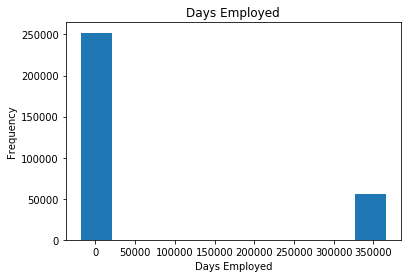

In [28]:
train_set['DAYS_EMPLOYED'].plot.hist(title="Days Employed")
plt.xlabel("Days Employed")

In [29]:
print("The number of anomalies in this column:",(train_set['DAYS_EMPLOYED'] == 365243).sum())

The number of anomalies in this column: 55374


Considering there are 55374 anomalies, and all these have the exact same value, they might be heavily correlated or share something in common. After making this assumption, it would be safer to replace their values with the same value.

Likewise, for the test set we also find anomalies:

In [30]:
print("Number of anomalies in the test set:",(test_set['DAYS_EMPLOYED'] == 365243).sum())

Number of anomalies in the test set: 9274


We replace the anomalies with NaN and create and additional column such that the machine learning algorithm is able to detect if an instance has been changed for being an anomaly.

In [31]:
# Creates an anomaly column in both sets
train_set['DAYS_EMPLOYED_ANOM'] = (train_set['DAYS_EMPLOYED'] == 365243)
test_set['DAYS_EMPLOYED_ANOM'] = (test_set['DAYS_EMPLOYED'] == 365243)

# Replaces all anomalies in both sets with NaN
train_set['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)
test_set['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)

train_set['DAYS_EMPLOYED'].plot.hist(title="Days Employed (after anomalies replaced)")
plt.xlabel("Days Employed")

In [32]:
print("Amount of anomalies(NaN) in training set %d. Amount of anomalies (NaN) in test set %d" % (train_set["DAYS_EMPLOYED_ANOM"].sum(), test_set["DAYS_EMPLOYED_ANOM"].sum()))

Amount of anomalies(NaN) in training set 55374. Amount of anomalies (NaN) in test set 9274


### Correlations

Now we want to take a loot at the features we have and how they correlate with the target value. We still have all the features we started with (and more since we split categorical variables into multiple columns). Pandas come with a built-in corr() method where you can specify three methods for calculating the correlations between an attribute. 

We're looking for correlation coefficients that range close to 1 (positive correlation) or -1 (negative correlation). 0 means there is no correlation. This doesn't necessarily portray the real correlations, but can give good indicators.

In [33]:
correlations = train_set.corr()['TARGET'].sort_values()

In [34]:
print("The most positive correlations\n\n",correlations.tail(20))


The most positive correlations

 DEF_60_CNT_SOCIAL_CIRCLE                             0.031276
DEF_30_CNT_SOCIAL_CIRCLE                             0.032248
LIVE_CITY_NOT_WORK_CITY                              0.032518
OWN_CAR_AGE                                          0.037612
DAYS_REGISTRATION                                    0.041975
OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                 

In [35]:
print("The most negative correlations\n\n",correlations.head(40))

The most negative correlations

 EXT_SOURCE_3                           -0.178919
EXT_SOURCE_2                           -0.160472
EXT_SOURCE_1                           -0.155317
NAME_EDUCATION_TYPE_Higher education   -0.056593
CODE_GENDER_F                          -0.054704
NAME_INCOME_TYPE_Pensioner             -0.046209
DAYS_EMPLOYED_ANOM                     -0.045987
ORGANIZATION_TYPE_XNA                  -0.045987
FLOORSMAX_AVG                          -0.044003
FLOORSMAX_MEDI                         -0.043768
FLOORSMAX_MODE                         -0.043226
EMERGENCYSTATE_MODE_No                 -0.042201
HOUSETYPE_MODE_block of flats          -0.040594
AMT_GOODS_PRICE                        -0.039645
REGION_POPULATION_RELATIVE             -0.037227
ELEVATORS_AVG                          -0.034199
ELEVATORS_MEDI                         -0.033863
FLOORSMIN_AVG                          -0.033614
FLOORSMIN_MEDI                         -0.033394
WALLSMATERIAL_MODE_Panel            

'DAYS_BIRTH' has the highest positive correlation with 'DAYS_EMPLOYED' close behind. However, this feature shows the applicants age in days, but as a negative number. This tells a story of the older the applicant, the less likely he is to repay the loan. Below we change 'DAYS_BIRTH' from a negative to a positive feature and rerun the correlation algorithm on it. 

But by far the strongest correlation lays in the negative section. All three 'EXT_SOURCE' score close to three times as high as the other highest negative correlated columns.

In [36]:
train_set['DAYS_BIRTH'] = abs(train_set['DAYS_BIRTH'])
train_set['DAYS_BIRTH'].corr(train_set['TARGET'])
#train_set['TARGET'].corr(train_set['DAYS_BIRTH'])

-0.07823930830982737

Now the correlations tells us that as the applicants get older, he is more likely to repay the loan (negative means further away from the target value, which is 1). 

Plotting this into a histogram to get an overview of the distribution of age.

Text(0,0.5,'Applicants')

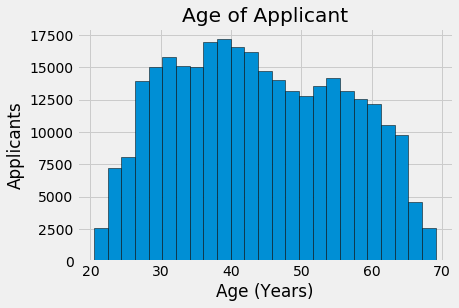

In [37]:
# One type of style sheet
plt.style.use("fivethirtyeight")

# Plotting years instead of days
plt.hist(train_set['DAYS_BIRTH'] / 365, edgecolor='k', bins=25)
plt.title('Age of Applicant')
plt.xlabel('Age (Years)')
plt.ylabel('Applicants')

**Kernel Density Estimation (KDE)** is a way to estimate the probability density function of a random variable. We will use it here on 'TARGET' and 'DAYS_BIRTH' to get a sort of smoothed histogram.

Text(0.5,1,'Distribution of Ages')

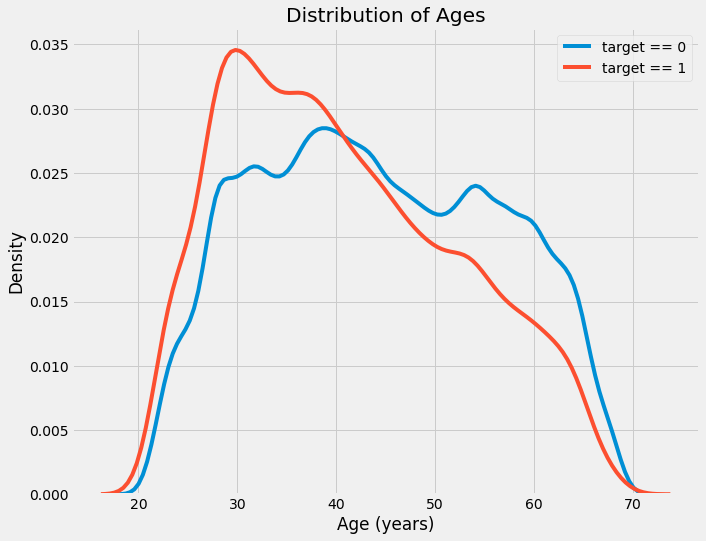

In [38]:
import seaborn as sns

plt.figure(figsize = (10, 8))

# Loans repaid
sns.kdeplot(train_set.loc[train_set['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# Loans not repaid
sns.kdeplot(train_set.loc[train_set['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages')

What can we extract from this? The orange line show correlation between age and loan not being repaid. We see it peek on the side of the younger applicants. Even though the correlation isn't very strong, it is one of the strongest we have in the dataset.

Let's follow the orange line of failing to repay loans in a histogram.

In [39]:
age_data = train_set[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH']/365

age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20,70,num=11))
age_data.head(15)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [40]:
# Convert to age groups for plotting
age_groups = age_data.groupby('YEARS_BIRTH').mean()

In [41]:
#plt.figure(figsize=(8,8))

# Graph the age bins and the average of the target as a bar plot
#plt.bar(age_groups.index.astype(str), 100*age_groups['TARGET'])

# Plot labeling
#plt.xticks(rotation = 75)
#plt.xlabel('Age Group (years)')
#plt.ylabel('Failure to Repay (%)')
#plt.title('Failure to Repay by Age Group')

We observe the same trend here. The correlation coefficient between ```target``` and ```age``` peaks at the younger applicants and slopes downwards as the applicants get older. Even though the correlation coefficient isn't very strong, it is one of the strongest of the ones in the dataset and it shows a clear trend. 

#### Exterior Sources

The features that showed strongest correlation were the three ```EXT_SOURCE_1```, ```EXT_SOURCE_2``` and ```EXT_SOURCE_3```. It is gonna be interesting to see what we can extract from these three features as we take a closer look at them. The column description list them as "Normalized score from external data source" which is very brief and unclear. Even though we don't know what they really represent, we know that they are best features we got currently, in terms of correlation with our target values.

We will take a look at the correlations between our strongest features in a table

In [46]:
# Each row shows the correlation between one feature and the rest
top_features = train_set[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
top_features_corrs = top_features.corr()
top_features_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,1.000000


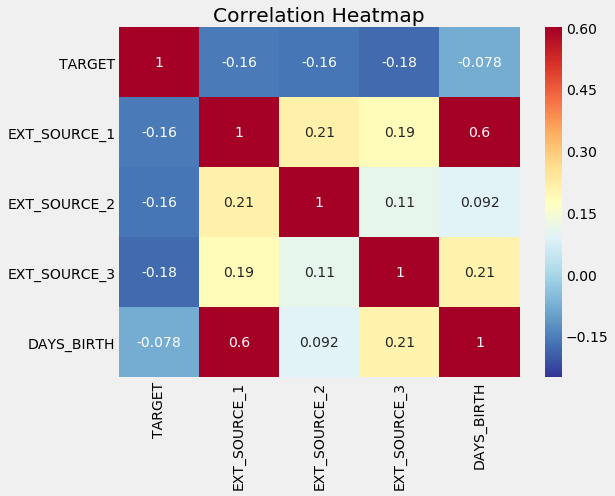

In [47]:
# A heatmap can present the data even clearer
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(top_features_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

We notice right away from the bright red color that ```EXT_SOURCE_1``` and ```DAYS_BIRTH``` strongly correlated. This is a positive correlation, meaning that as ```EXT_SOURCE_1``` increases```DAYS_BIRTH``` will increase. Again, as ```DAYS_BIRTH``` increases we know that the chance of repaying a loan increases aswell (because of the negative correlation).

Let's plot both target values and each ```EXT_SOURCE``` to see the distribution of each of these features.

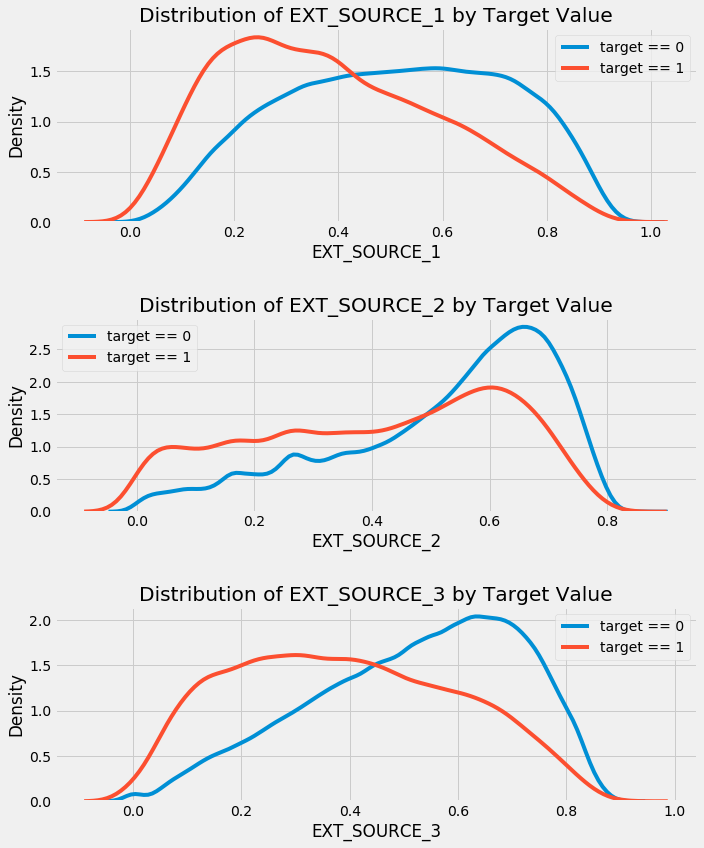

In [48]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(train_set.loc[train_set['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(train_set.loc[train_set['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

```EXT_SOURCE_3``` is the least correlated of the three (altough not by a lot), but it shows the most promising distribution. Compared to ```EXT_SOURCE_2``` it shows a much clearer relationship to the target value. We see that as the ```EXT_SOURCE_3``` value increase, the loan is more likely to be repaid. At the same time, the target value 0 drops gradually. The amount of loans not being repaid decreases.

### Scatter matrix

We use pandas' scatter_matrix to check for relationships between our most important attributes

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8c421f5978>,
      dtype=object)

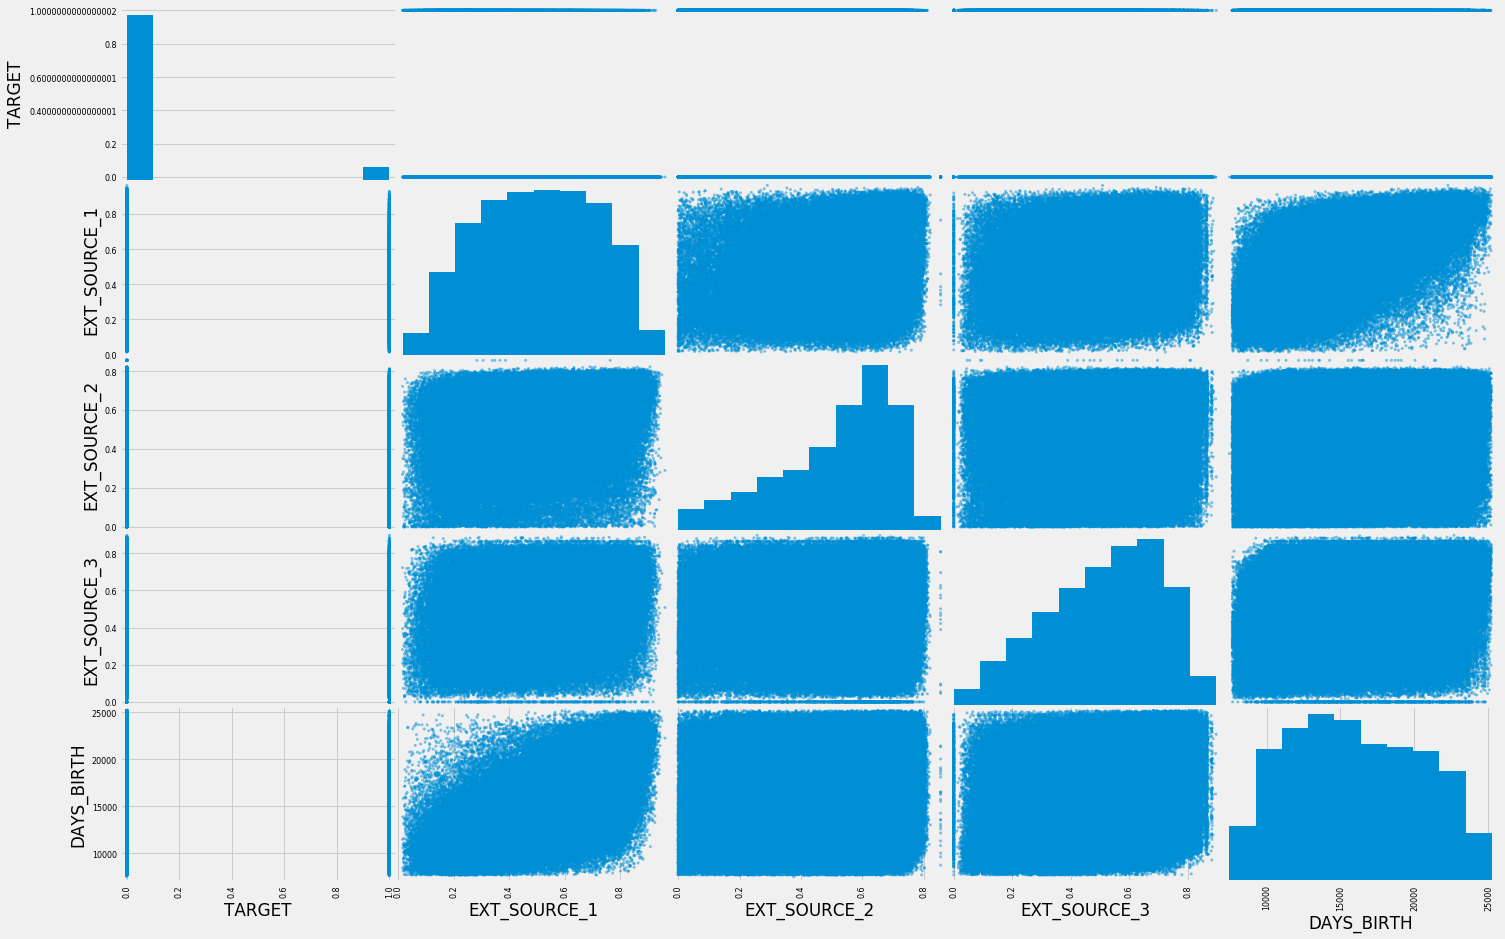

In [79]:
from pandas.tools.plotting import scatter_matrix

important_attributes = ['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','DAYS_BIRTH']
scatter_matrix(train_set[important_attributes], figsize=(22,15))

  
  
 Let's plot some other interesting attributes into a scatter matrix:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8c423683c8>,
      dtype=object)

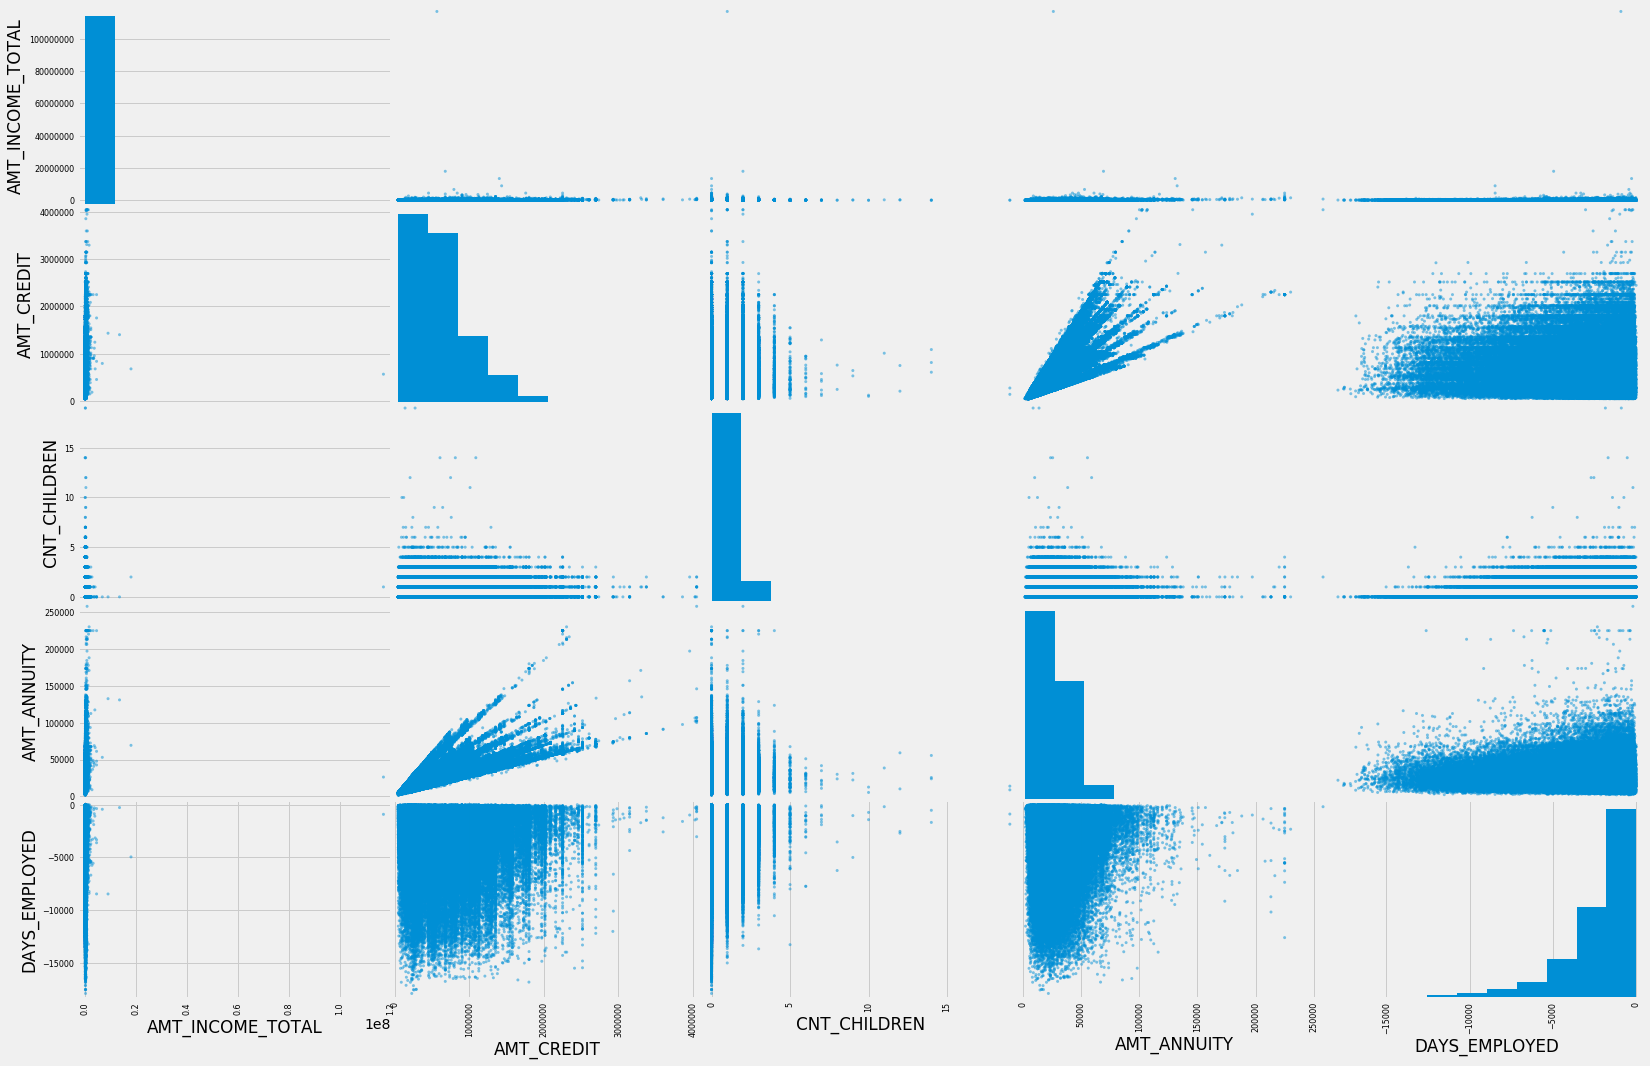

In [81]:
other_attributes = ['AMT_INCOME_TOTAL','AMT_CREDIT','CNT_CHILDREN','AMT_ANNUITY','DAYS_EMPLOYED']
scatter_matrix(train_set[other_attributes], figsize=(25,17))

# (Relationship between variables and relationship between single variables)

(like pairs plot)

#### Repaid vs not repaid

Repaid loans (0) compared to not repaid loans (1) shows us that, *there are far more repaid loans than not repaid loans*. Most machine learning algorithms work best when the number of classes are roughly equal. This is called the *class imbalance problem*. We want to emphasize to the machine learning algorithm that it's important to detect the few cases where a loan is likely not to be repaid, rather than focusing only on high accuracy.

In [42]:
train_set["TARGET"].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [43]:
num_of_not_repaid = train_set["TARGET"].sum()
not_repaid_percentage = num_of_not_repaid / train_set["TARGET"].count() * 100
print("%.2f" % not_repaid_percentage, "% did not repay their loans")

8.07 % did not repay their loans


#### (Put on halt for now) Training a temporary Binary Classifier on income and credit alone

We create a temporary set of the total amount of income and credit and explore what kind of predictions we can get from it.

In [44]:
from sklearn.linear_model import SGDClassifier

income_and_credit = train_set[["AMT_INCOME_TOTAL","AMT_CREDIT"]]
income_and_credit_labeled = train_set["TARGET"]
income_and_credit.head()

,AMT_INCOME_TOTAL,AMT_CREDIT
0,202500.0,406597.5
1,270000.0,1293502.5
2,67500.0,135000.0
3,135000.0,312682.5
4,121500.0,513000.0


In [45]:
# using random state makes the results reproducible
sgd_clf = SGDClassifier(random_state=30)
sgd_clf.fit(income_and_credit, income_and_credit_labeled)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=30, shuffle=True,
       tol=None, verbose=0, warm_start=False)

Predicting the first and second row, which we know are 1 and 0 respectively

## Feature Engineering

This is probably the most important part of the project. We all work on certain modifications of the same models, but the features and the whole set of data we feed the models, may greatly differ. Removing useless features that just muddies the process, and constructing new features from old ones, may greatly improve the model.

### Creating new features from old ones

We have a lot of features which didn't seem to correlate very well with our target values. However, there are a lot of features which naturally come to mind when discussing this topic of whether an applicant will be able to repay their loans. One, that we already have covered a bit, is age. But there are others, like an applicant's job status, annual income, the loan, the credit amount, how many days employed and how many children the client has.

On their own they might not be very important, but if you combine some of them, it could lead to features that more accurately predict when a loan will be repaid by a client.

In [55]:
building_train_set = train_set.copy()
building_test_set = test_set.copy()

Let's create some additional features  

* INCOME_CHILDREN_RATIO: total amount of income divided by number of children
* CREDIT_INCOME_PERCENT: the percentage of the credit amount relative to a client's income
* ANNUITY_INCOME_PERCENT: the percentage of the loan annuity relative to a client's income
* CREDIT_TERM: the length of the payment in months
* DAYS_UNEMPLOYED: days unemployed
* INCOME_DAYS_EMPLOYED: income divided by days employed
* DAYS_EMPLOYED_PERCENT: the percentage of the days employed relative to the client's age


In [67]:
building_train_set['INCOME_CHILDREN_RATIO'] = building_train_set['AMT_INCOME_TOTAL'] / 1 + building_train_set['CNT_CHILDREN']
building_train_set['CREDIT_INCOME_PERCENT'] = building_train_set['AMT_CREDIT'] / building_train_set['AMT_INCOME_TOTAL']
building_train_set['ANNUITY_INCOME_PERCENT'] = building_train_set['AMT_ANNUITY'] / building_train_set['AMT_INCOME_TOTAL']
building_train_set['CREDIT_TERM'] = building_train_set['AMT_ANNUITY'] / building_train_set['AMT_CREDIT']
building_train_set['DAYS_UNEMPLOYED'] = building_train_set['DAYS_BIRTH'] - abs(building_train_set['DAYS_EMPLOYED'])
building_train_set['INCOME_DAYS_EMPLOYED'] = building_train_set['AMT_INCOME_TOTAL'] / abs(building_train_set['DAYS_EMPLOYED'])
building_train_set['DAYS_EMPLOYED_PERCENT'] = building_train_set['DAYS_EMPLOYED'] / building_train_set['DAYS_BIRTH']

In [68]:
building_test_set['INCOME_CHILDREN_RATIO'] = building_test_set['AMT_INCOME_TOTAL'] / 1 + building_test_set['CNT_CHILDREN']
building_test_set['CREDIT_INCOME_PERCENT'] = building_test_set['AMT_CREDIT'] / building_test_set['AMT_INCOME_TOTAL']
building_test_set['ANNUITY_INCOME_PERCENT'] = building_test_set['AMT_ANNUITY'] / building_test_set['AMT_INCOME_TOTAL']
building_test_set['CREDIT_TERM'] = building_test_set['AMT_ANNUITY'] / building_test_set['AMT_CREDIT']
building_test_set['DAYS_UNEMPLOYED'] = building_test_set['DAYS_BIRTH'] - abs(building_test_set['DAYS_EMPLOYED'])
building_test_set['INCOME_DAYS_EMPLOYED'] = building_test_set['AMT_INCOME_TOTAL'] / abs(building_test_set['DAYS_EMPLOYED'])
building_test_set['DAYS_EMPLOYED_PERCENT'] = building_test_set['DAYS_EMPLOYED'] / building_test_set['DAYS_BIRTH']

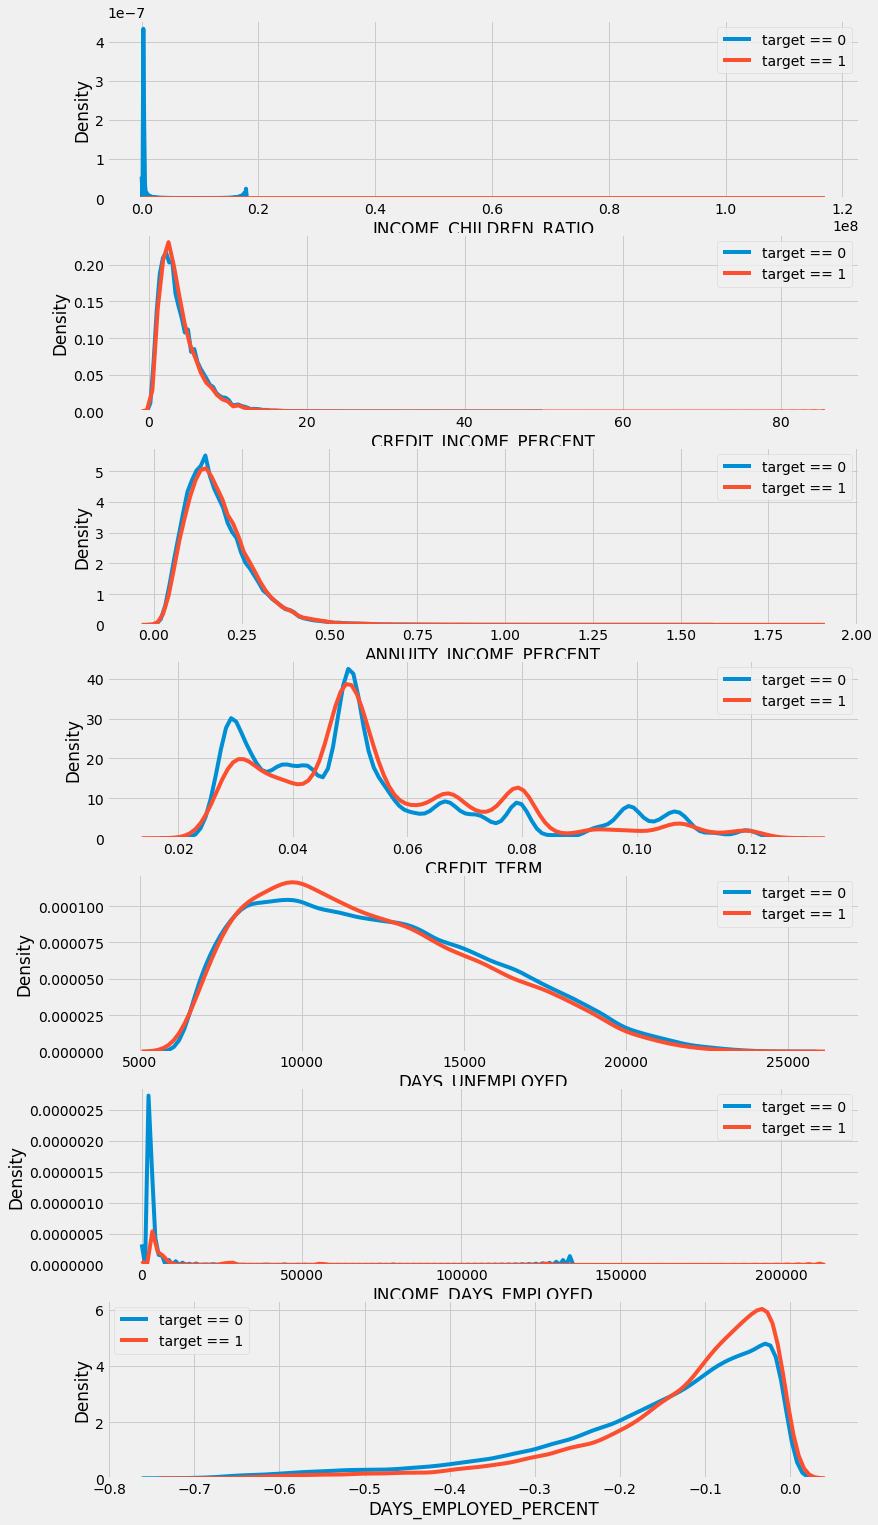

In [74]:
plt.figure(figsize = (12, 25))
# iterate through the new features
for i, feature in enumerate(['INCOME_CHILDREN_RATIO', 'CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM','DAYS_UNEMPLOYED', 'INCOME_DAYS_EMPLOYED', 'DAYS_EMPLOYED_PERCENT']):
    
    # create a new subplot for each source
    plt.subplot(7, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(building_train_set.loc[building_train_set['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(building_train_set.loc[building_train_set['TARGET'] == 1, feature], label = 'target == 1')
    
    # Label the plots
    #plt.title('Distribution of %s by Target Value' % feature)
    plt.title('')
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    

Let's run another correlation matrix with the new features.

In [2]:
corr_matrix = building_train_set.corr()
corr_matrix['TARGET'].sort_value(ascending=False)

NameError: name 'building_train_set' is not defined

## First model

In [63]:
#train_set.select_dtypes('float64').apply(pd.Series.nunique, axis=0)
train_set['DAYS_EMPLOYED']

0         -637.0
1        -1188.0
2         -225.0
3        -3039.0
4        -3038.0
5        -1588.0
6        -3130.0
7         -449.0
8            NaN
9        -2019.0
10        -679.0
11           NaN
12       -2717.0
13       -3028.0
14        -203.0
15       -1157.0
16       -1317.0
17        -191.0
18       -7804.0
19       -2038.0
20       -4286.0
21       -1652.0
22       -4306.0
23           NaN
24        -746.0
25       -3494.0
26       -2628.0
27       -1234.0
28       -1796.0
29       -1010.0
           ...  
307481   -3147.0
307482    -226.0
307483       NaN
307484    -328.0
307485    -670.0
307486   -1185.0
307487       NaN
307488   -1218.0
307489    -286.0
307490   -1928.0
307491   -1953.0
307492   -1618.0
307493   -2306.0
307494   -6573.0
307495   -7438.0
307496   -2178.0
307497   -1222.0
307498   -3689.0
307499   -8694.0
307500   -5326.0
307501   -1046.0
307502   -8736.0
307503    -399.0
307504   -7258.0
307505       NaN
307506    -236.0
307507       NaN
307508   -7921